In [2]:
%pip install pandas mlxtend matplotlib seaborn openpyxl



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Test1

Test2

In [3]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings("ignore")

# ====== 1. Load and Clean Data ======
def load_and_clean(file_path, sheet="รายงานรายวัน"):
    df = pd.read_excel(file_path, sheet_name=sheet)
    df.columns = df.iloc[5]
    df = df[6:].reset_index(drop=True)
    df = df[["รหัสสินค้า", "ชื่อสินค้า", "วันที่"]].dropna()
    df["วันที่"] = pd.to_datetime(df["วันที่"], dayfirst=True, errors="coerce")
    return df

df1 = load_and_clean("data/month1.xlsx")
df2 = load_and_clean("data/month2.xlsx")
df3 = load_and_clean("data/month3.xlsx")
df = pd.concat([df1, df2, df3], ignore_index=True)

# ====== 2. Refined Category Mapping ======
def refined_category(name):
    name = str(name)
    if any(x in name for x in ["ເນື້ອຫມູ", "ໝູ", "ຊີ້ນໝູ"]):
        return "ເນື້ອຫມູ"
    elif any(x in name for x in ["ເນື້ອໄກ່", "ໄກ່"]):
        return "ເນື້ອໄກ່"
    elif any(x in name for x in ["ປາ", "ເນື້ອປາ"]):
        return "ປາ"
    elif any(x in name for x in ["ນ້ຳ", "ນ້ຳປາ", "ນໍ້າ", "ນ້ຳຈິ້ມ", "ນ້ຳມັນ"]):
        return "ນ້ຳ / ຊອດ"
    elif any(x in name for x in ["ແຈ່ວ", "ເຄື່ອງປຸງ", "ແປ້ງ", "ຂົ້ວ"]):
        return "ເຄື່ອງປຸງ"
    else:
        return "ອື່ນໆ"

df["category"] = df["ชื่อสินค้า"].apply(refined_category)

# ====== 3. Filter 180 Days & Popular Items (≥1) ======
today = df["วันที่"].max()
df_recent = df[df["วันที่"] >= today - timedelta(days=180)]
popular_items = df_recent["ชื่อสินค้า"].value_counts()
df_recent = df_recent[df_recent["ชื่อสินค้า"].isin(popular_items[popular_items >= 3].index)]

# ====== 4. Group Transaction by Date ======
grouped = df_recent.groupby("วันที่")["ชื่อสินค้า"].apply(lambda x: list(set(x))).reset_index()
te = TransactionEncoder()
te_ary = te.fit(grouped["ชื่อสินค้า"]).transform(grouped["ชื่อสินค้า"])
basket = pd.DataFrame(te_ary, columns=te.columns_)



🔧 Train Size: 41, Test Size: 11
📦 Discovered Rules: 1327

📊 Top 10 Rules:
                          antecedents  \
0          (ເຄື່ອງໃຊ້ທົ່ວໄປ, ຊີ້ນສົດ)   
1                       (ປະເພດ-ເສັ້ນ)   
2                          (ເປັດຊີພີ)   
3  (ເປັດຊີພີ, ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ)   
4            (ເປັດຊີພີ, ຜັກປອດສານພິດ)   
5                          (ເປັດຊີພີ)   
6          (ເປັດຊີພີ, ອາຫານສຳເລັດຮູບ)   
7                          (ເປັດຊີພີ)   
8          (ເປັດຊີພີ, ອາຫານສຳເລັດຮູບ)   
9                          (ເປັດຊີພີ)   

                                consequents   support  confidence      lift  
0                            (ຜັກປອດສານພິດ)  0.536585         1.0  1.025000  
1                  (ຜັກປອດສານພິດ, ນໍ້າແຈ່ວ)  0.195122         1.0  1.025000  
2                            (ຜັກປອດສານພິດ)  0.146341         1.0  1.025000  
3                            (ຜັກປອດສານພິດ)  0.146341         1.0  1.025000  
4                  (ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ)  0.146341         1.0  1.576923  
5    (

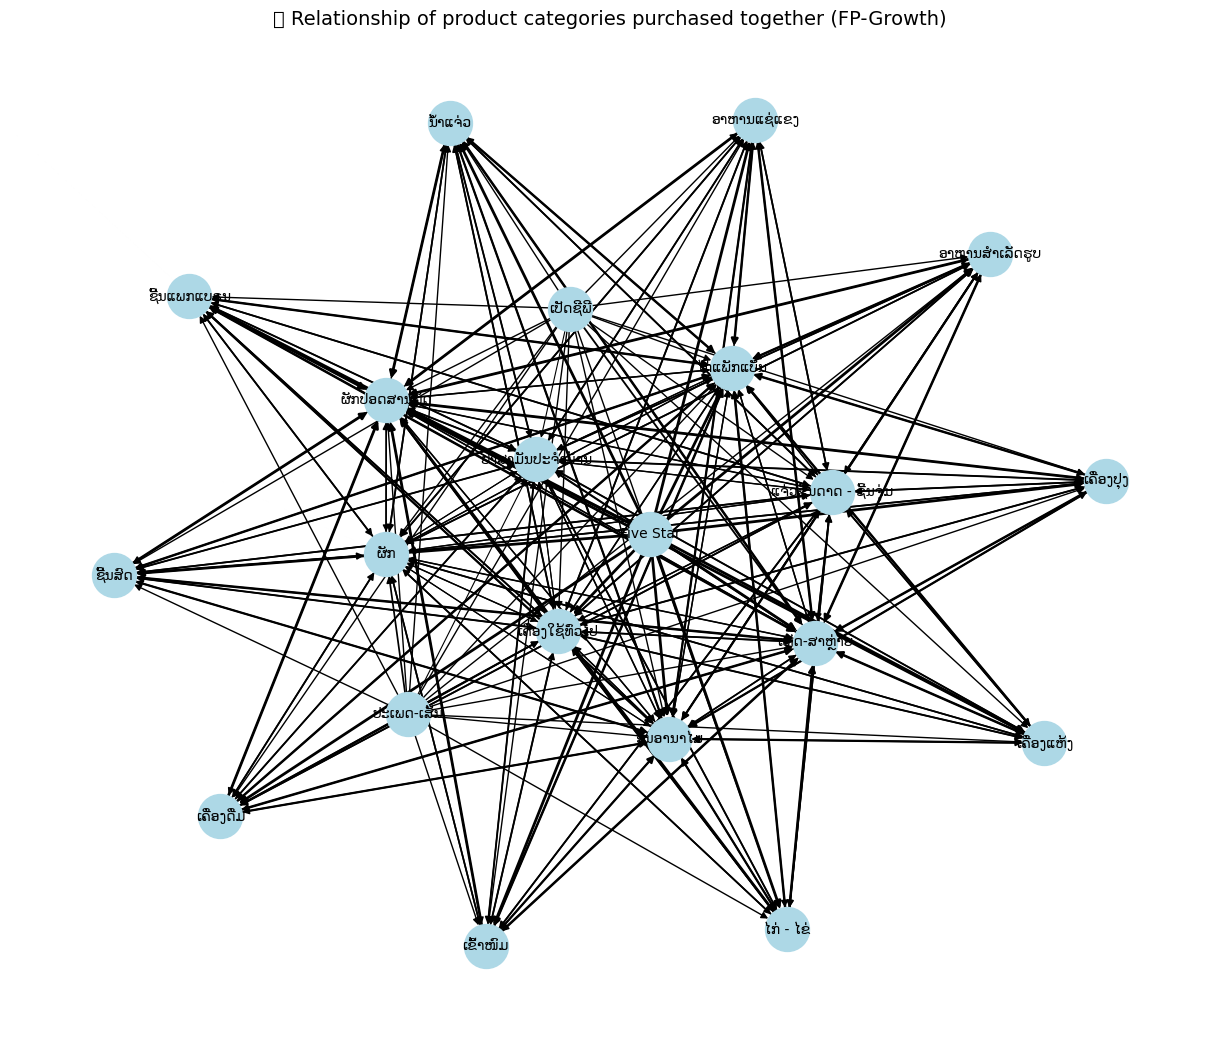

In [4]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from datetime import timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import warnings

warnings.filterwarnings("ignore")

# ====== 1. Load and Clean Data ======
def load_and_clean(file_path, sheet="รายงานรายวัน"):
    df = pd.read_excel(file_path, sheet_name=sheet)
    df.columns = df.iloc[5]  # ใช้แถวที่ 6 เป็น header จริง
    df = df[6:].reset_index(drop=True)
    df = df[["รหัสสินค้า", "ชื่อสินค้า", "วันที่"]].dropna()
    df["วันที่"] = pd.to_datetime(df["วันที่"], dayfirst=True, errors="coerce")
    return df

# ====== 2. Load Data ======
df1 = load_and_clean("data/month1.xlsx")
df2 = load_and_clean("data/month2.xlsx")
df3 = load_and_clean("data/month3.xlsx")
df = pd.concat([df1, df2, df3], ignore_index=True)

# ====== 3. Merge หมวดหมู่ ======
product_cats = pd.read_csv("data/Extracted_Product_Categories.csv")  # "ชื่อสินค้า", "หมวดหมู่"
df = df.merge(product_cats, on="ชื่อสินค้า", how="left")
df["category"] = df["หมวดหมู่"].astype(str)
df = df[df["category"] != "-"]

# ====== 4. Filter: 180 วันล่าสุด + หมวดหมู่ยอดนิยม (≥ 3 ครั้ง) ======
today = df["วันที่"].max()
df_recent = df[df["วันที่"] >= today - timedelta(days=365)]
popular = df_recent["category"].value_counts()
df_recent = df_recent[df_recent["category"].isin(popular[popular >= 3].index)]

# ====== 5. สร้าง Basket ======
grouped = df_recent.groupby("วันที่")["category"].apply(lambda x: list(set(x))).reset_index()
te = TransactionEncoder()
te_ary = te.fit(grouped["category"]).transform(grouped["category"])
basket = pd.DataFrame(te_ary, columns=te.columns_)

# ====== 6. Split Train/Test ======
train_basket, test_basket = train_test_split(basket, test_size=0.2, random_state=42)
print(f"🔧 Train Size: {len(train_basket)}, Test Size: {len(test_basket)}")

# ====== 7. FP-Growth Training ======
frequent_itemsets = fpgrowth(train_basket, min_support=0.04, use_colnames=True, max_len=3)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
rules = rules[rules["lift"] > 1.0].sort_values(by="confidence", ascending=False).reset_index(drop=True)

print(f"📦 Discovered Rules: {len(rules)}")
print("\n📊 Top 10 Rules:")
print(rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10))

# ====== 8. Evaluate Accuracy ======
correct = 0
evaluated = 0

for _, row in rules.iterrows():
    antecedents = set(row["antecedents"])
    consequents = set(row["consequents"])
    
    for _, transaction in test_basket.iterrows():
        basket_items = set(test_basket.columns[transaction])
        if antecedents.issubset(basket_items):
            evaluated += 1
            if consequents.issubset(basket_items):
                correct += 1

if evaluated > 0:
    accuracy = correct / evaluated
    print(f"\n✅ Accuracy: {accuracy:.2%} ({correct}/{evaluated})")
else:
    print("\n⚠️ ไม่มีรายการ Test ที่ตรงกับ Antecedents ใดๆ")

# ====== 9. Visualization ======
G = nx.DiGraph()
for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges(data=True)
weights = [d['weight'] * 2 for (_, _, d) in edges]
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, arrows=True, width=weights)
plt.title("📌 Relationship of product categories purchased together (FP-Growth)", fontsize=14)
plt.show()


In [5]:
def recommend_next_items(items, rules, top_k=3):
    items = set(items)
    candidates = []

    for _, row in rules.iterrows():
        if items.issuperset(set(row["antecedents"])):
            candidates.append((list(row["consequents"])[0], row["confidence"]))

    # เรียงตาม confidence
    candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
    return [item for item, _ in candidates[:top_k]]

# ทดลอง:
print("🎯 Recommend:", recommend_next_items(["ຜັກປອດສານພິດ", "ເປັດຊີພີ"], rules))


🎯 Recommend: ['ຜັກປອດສານພິດ', 'ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ', 'ແຈ່ວຊີ້ນດາດ - ຊີ້ນຈຸ່ມ']


In [6]:
tp = 0  # ทำนายถูก
fp = 0  # ทำนายผิด
fn = 0  # ไม่ทำนายแต่ควรทำนาย

for _, row in rules.iterrows():
    antecedents = set(row["antecedents"])
    consequents = set(row["consequents"])

    for _, transaction in test_basket.iterrows():
        basket_items = set(test_basket.columns[transaction])
        if antecedents.issubset(basket_items):
            if consequents.issubset(basket_items):
                tp += 1
            else:
                fp += 1
        elif consequents.issubset(basket_items):
            fn += 1

precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

print(f"\n📊 Precision: {precision:.2%}")
print(f"📊 Recall: {recall:.2%}")
print(f"📊 F1 Score: {f1:.2%}")



📊 Precision: 70.78%
📊 Recall: 51.79%
📊 F1 Score: 59.82%


In [7]:
# สมมุติว่าคุณมี rules จากการ train แล้ว เช่น:
from mlxtend.frequent_patterns import association_rules

# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
top10_rules = rules.sort_values(by='confidence', ascending=False).head(10)


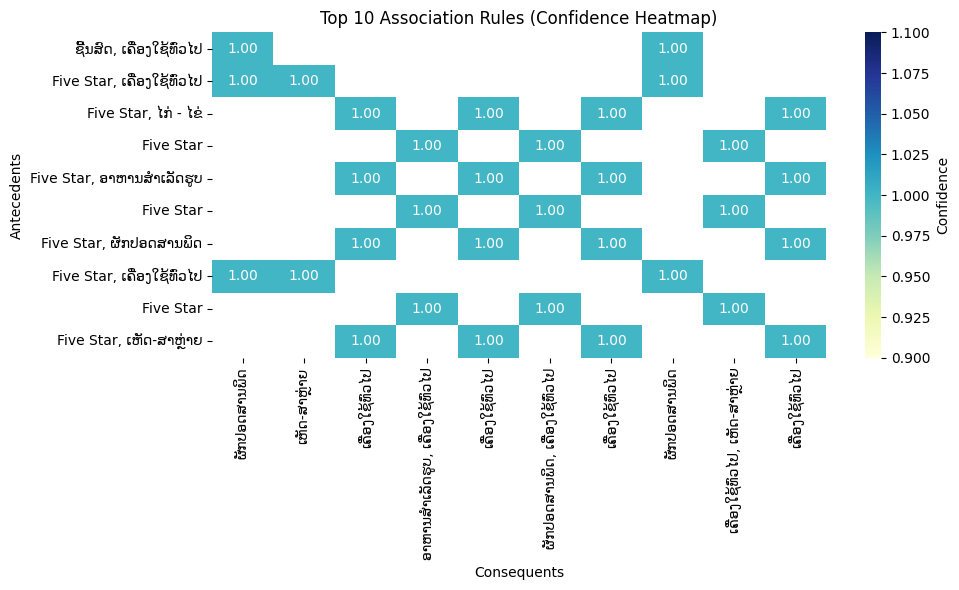

In [8]:
import seaborn as sns

# แปลงชื่อให้อ่านง่าย
def fs_to_str(fs):
    return ', '.join(sorted(fs))

top10_rules['antecedents_str'] = top10_rules['antecedents'].apply(fs_to_str)
top10_rules['consequents_str'] = top10_rules['consequents'].apply(fs_to_str)

# สร้าง DataFrame สำหรับ heatmap
heatmap_df = pd.DataFrame(index=top10_rules['antecedents_str'],
                          columns=top10_rules['consequents_str'])

for _, row in top10_rules.iterrows():
    heatmap_df.loc[row['antecedents_str'], row['consequents_str']] = row['confidence']

# วาด heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Confidence'})
plt.title("Top 10 Association Rules (Confidence Heatmap)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.tight_layout()
plt.show()


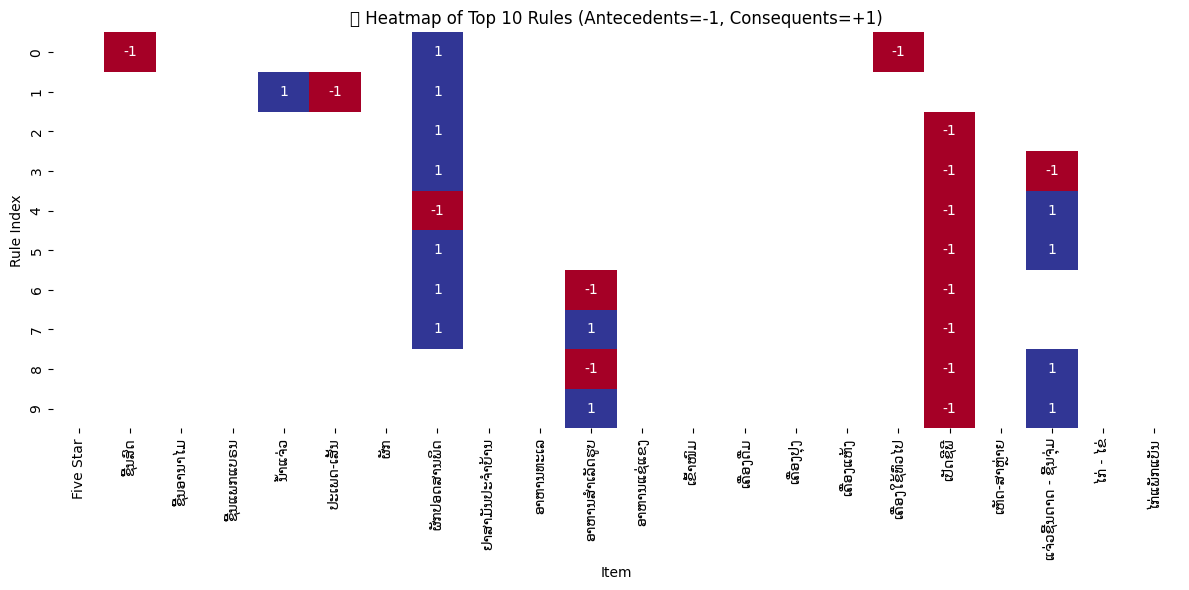

In [9]:
import numpy as np
import seaborn as sns

# ดึง Top 10 rules ที่ confidence สูงสุด
top_rules = rules.nlargest(10, 'confidence')

# สร้าง DataFrame สำหรับ Heatmap
heatmap_data = pd.DataFrame(0, index=range(10), columns=te.columns_)

for i, row in top_rules.iterrows():
    for item in row["antecedents"]:
        heatmap_data.loc[i, item] = -1  # ใช้ -1 แทน antecedent
    for item in row["consequents"]:
        heatmap_data.loc[i, item] = 1   # ใช้ +1 แทน consequent

# ✅ ใช้ np.nan แทน None เพื่อไม่ให้ dtype เป็น object
heatmap_data = heatmap_data.replace(0, np.nan)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlBu", center=0, cbar=False)
plt.title("🔥 Heatmap of Top 10 Rules (Antecedents=-1, Consequents=+1)")
plt.xlabel("Item")
plt.ylabel("Rule Index")
plt.tight_layout()
plt.show()


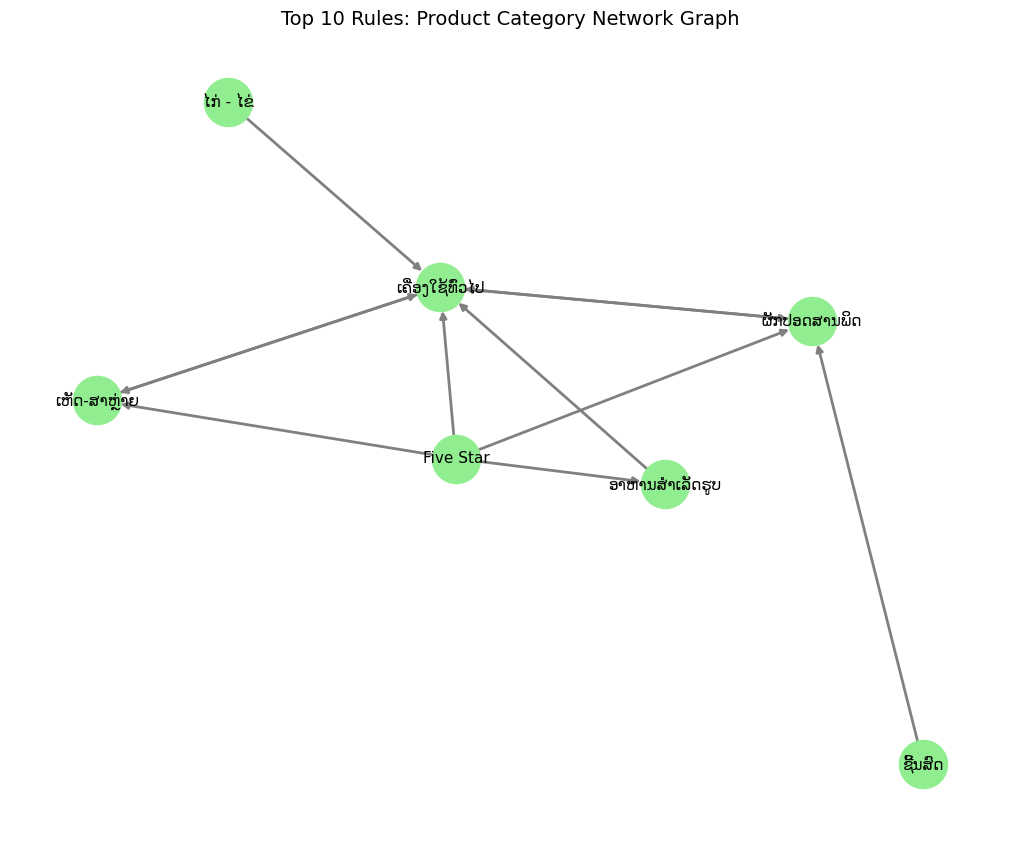

In [10]:
G = nx.DiGraph()
for _, row in top10_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges(data=True)
weights = [d['weight'] * 2 for (_, _, d) in edges]
nx.draw(G, pos, with_labels=True, node_size=1200, node_color="lightgreen",
        font_size=11, arrows=True, width=weights, edge_color="gray")
plt.title("Top 10 Rules: Product Category Network Graph", fontsize=14)
plt.show()


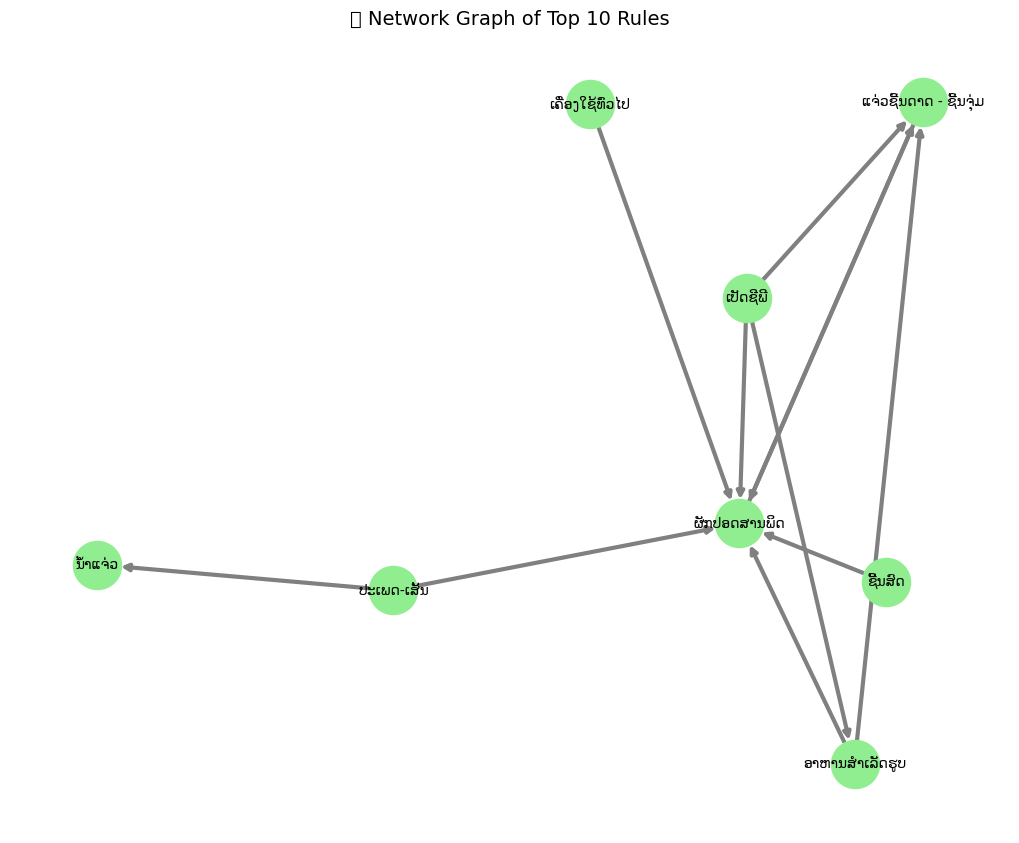

In [11]:
# use only  top 10 rules
top10_rules = rules.head(10)

G_top = nx.DiGraph()
for _, row in top10_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G_top.add_edge(str(a), str(c), weight=row['confidence'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_top, k=0.7)
weights = [d['weight'] * 3 for (_, _, d) in G_top.edges(data=True)]
nx.draw(
    G_top, pos,
    with_labels=True,
    node_size=1200,
    node_color="lightgreen",
    font_size=10,
    arrows=True,
    width=weights,
    edge_color="gray"
)
plt.title("📡 Network Graph of Top 10 Rules", fontsize=14)
plt.show()


In [13]:
rules['antecedents'] = rules['antecedents'].apply(list)
rules['consequents'] = rules['consequents'].apply(list)
rules.to_json("rules.json", orient="records", force_ascii=False)
